# Proyecto Integrador IV
> E-Commerce Data Pipeline

En este notebook, primero ejecutaremos todos los componentes de nuestro pipeline ELT y luego realizaremos visualizaciones con la información resultante


In [1]:
# Importing the necessary libraries
from pandas import DataFrame
from sqlalchemy import create_engine
from typing import Dict
from pathlib import Path

from src.transform import QueryEnum
from src import config
from src.transform import run_queries
from src.extract import extract
from src.load import load
from src.plots import (
    plot_freight_value_weight_relationship,
    plot_global_amount_order_status,
    plot_real_vs_predicted_delivered_time,
    plot_revenue_by_month_year,
    plot_revenue_per_state,
    plot_top_10_least_revenue_categories,
    plot_top_10_revenue_categories,
    plot_top_10_revenue_categories_ammount,
    plot_delivery_date_difference,
    plot_order_amount_per_day_with_holidays,
)

In [2]:
# Create the database sql file
Path(config.SQLITE_BD_ABSOLUTE_PATH).touch()

# Create the database connection
ENGINE = create_engine(rf"sqlite:///{config.SQLITE_BD_ABSOLUTE_PATH}", echo=False)

### 1. Extract

Aquí estarás extrayendo la información de las fuentes.

In [3]:
csv_folder = config.DATASET_ROOT_PATH
public_holidays_url = config.PUBLIC_HOLIDAYS_URL

# 1. Get the mapping of the csv files to the table names.
csv_table_mapping = config.get_csv_to_table_mapping()

# 2. Extract the data from the csv files, holidays and load them into the dataframes.
csv_dataframes = extract(csv_folder, csv_table_mapping, public_holidays_url)

### 2. Load

Usando los diferentes conjuntos de datos proporcionados, almacenarás todo en nuestro Data Warehouse.

In [4]:
load(data_frames=csv_dataframes, database=ENGINE)

### 3. Transform

Aquí transformarás las diferentes consultas en tablas. Hay dos secciones: una con las consultas relacionadas con los ingresos y otra con las consultas relacionadas con las entregas.

##### 3.1 Queries sobre ingresos

In [5]:
query_results: Dict[str, DataFrame] = run_queries(database=ENGINE)

                               order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
5      a4591c265e18cb1dcee52889e2d8acc3  503740e9ca751ccdda7ba28e9ab8f608   
6      136cce7faa42fdb2cefd53fdc79a6098  ed0271e0b7da060a393796590e7b737a   
7      6514b8ad8028c9f2cc2374ded245783f  9bdf08b4b3b52b5526ff42d37d47f222   
...                                 ...                               ...   
99433  9115830be804184b91f5c00f6f49f92d  da2124f134f5dfbce9d06f29bdb6c308   
99434  aa04ef5214580b06b10e2a378300db44  f01a6bfcc730456317e4081fe0c9940e   
99435  880675dff2150932f1601e1c07eadeeb  47cd45a6ac7b9fb16537df2ccffeb5ac   
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   

      order_status order_purchase_timestamp    order_approved_at  \
0      

In [6]:
# Transforming the revenue_by_month_year query to a table
revenue_by_month_year = query_results[QueryEnum.REVENUE_BY_MONTH_YEAR.value]
revenue_by_month_year

,month_no,month,Year2016,Year2017,Year2018
0,01,Jan,0.00,335197.86,697099.51
1,02,Feb,0.00,233601.47,870064.97
2,03,Mar,0.00,388132.87,1042897.06
3,04,Mar,0.00,308113.08,1300401.43
4,05,May,0.00,601070.25,1170348.65
5,06,Jun,0.00,502197.97,1171086.67
6,07,Jul,0.00,531271.71,948000.64
7,08,Jul,0.00,627367.19,1347216.73
8,09,Aug,0.00,670205.77,12875.18
9,10,Oct,34438.41,759903.98,347.95


In [7]:
# Transforming the top_10_revenue_categories query to a table
top_10_revenue_categories = query_results[QueryEnum.TOP_10_REVENUE_CATEGORIES.value]
top_10_revenue_categories

,Category,Num_order,Revenue
0,health_beauty,8647,1412089.53
1,watches_gifts,5493,1264016.98
2,bed_bath_table,9272,1225209.26
3,sports_leisure,7529,1118062.91
4,computers_accessories,6529,1032603.65
5,furniture_decor,6307,880329.92
6,housewares,5743,758392.25
7,cool_stuff,3559,691680.89
8,auto,3809,669319.92
9,garden_tools,3448,567145.68


In [8]:
# Transforming the top_10_least_revenue_categories query to a table
top_10_least_revenue_categories = query_results[
    QueryEnum.TOP_10_LEAST_REVENUE_CATEGORIES.value
]
top_10_least_revenue_categories

,Category,Num_order,Revenue
0,security_and_services,2,324.51
1,fashion_childrens_clothes,7,598.67
2,cds_dvds_musicals,12,954.99
3,home_comfort_2,24,1170.58
4,flowers,29,1598.91
5,diapers_and_hygiene,25,2046.19
6,arts_and_craftmanship,23,2184.14
7,la_cuisine,13,2388.54
8,fashion_sport,26,2657.55
9,fashio_female_clothing,36,3218.44


In [9]:
# Transforming the revenue_per_state query to a table
revenue_per_state = query_results[QueryEnum.REVENUE_PER_STATE.value]
revenue_per_state

,customer_state,Revenue
0,SP,5769081.27
1,RJ,2055690.45
2,MG,1819277.61
3,RS,861608.40
4,PR,781919.55
5,SC,595208.40
6,BA,591270.60
7,DF,346146.17
8,GO,334294.22
9,ES,317682.65


##### 3.2 Queries sobre entregas

In [10]:
# Transforming the delivery_date_difference query to a table
delivery_date_difference = query_results[QueryEnum.DELIVERY_DATE_DIFFERECE.value]
delivery_date_difference

,State,Delivery_Difference
0,AL,8
1,MA,9
2,BA,10
3,CE,10
4,ES,10
5,SE,10
6,MS,11
7,PI,11
8,RJ,11
9,SC,11


In [11]:
# Transforming the real vs predicted delivered time query to a table per month and year
real_vs_estimated_delivered_time = query_results[
    QueryEnum.REAL_VS_ESTIMATED_DELIVERED_TIME.value
]
real_vs_estimated_delivered_time

,month_no,month,Year2016_real_time,Year2017_real_time,Year2018_real_time,Year2016_estimated_time,Year2017_estimated_time,Year2018_estimated_time
0,01,Ene,NaN,8.602918,15.330987,NaN,31.242794,26.683252
1,02,Feb,NaN,10.331250,14.672381,NaN,34.873981,26.104765
2,03,Mar,NaN,11.908795,15.365344,NaN,25.749432,22.558378
3,04,Abr,NaN,12.813702,15.366259,NaN,26.811451,23.011034
4,05,May,NaN,12.943527,11.861215,NaN,24.907252,22.419256
5,06,Jun,NaN,11.679506,11.721084,NaN,24.614169,27.801868
6,07,Jul,NaN,11.289015,9.149208,NaN,23.095980,22.123831
7,08,Ago,NaN,11.000487,8.741144,NaN,23.493587,16.407960
8,09,Sep,NaN,12.487484,40.148743,NaN,22.067024,16.967427
9,10,Oct,14.480048,11.757649,114.608503,55.117775,23.625262,59.408579


In [12]:
# Transforming the global ammount of order status query to a table
global_ammount_order_status = query_results[QueryEnum.GLOBAL_AMMOUNT_ORDER_STATUS.value]
global_ammount_order_status

,order_status,Ammount
0,approved,2
1,canceled,625
2,created,5
3,delivered,96478
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


In [13]:
orders_per_day_and_holidays = query_results[
    QueryEnum.ORDERS_PER_DAY_AND_HOLIDAYS_2017.value
]
orders_per_day_and_holidays

,date,order_count,holiday
0,2017-01-05,32,False
1,2017-01-06,4,False
2,2017-01-07,4,False
3,2017-01-08,6,False
4,2017-01-09,5,False
...,...,...,...
356,2017-12-27,167,False
357,2017-12-28,146,False
358,2017-12-29,135,False
359,2017-12-30,97,False


In [14]:
freight_value_weight_relationship = query_results[
    QueryEnum.GET_FREIGHT_VALUE_WEIGHT_RELATIONSHIP.value
]
freight_value_weight_relationship

,order_id,freight_value,product_weight_g
0,00010242fe8c5a6d1ba2dd792cb16214,13.29,650.0
1,00018f77f2f0320c557190d7a144bdd3,19.93,30000.0
2,000229ec398224ef6ca0657da4fc703e,17.87,3050.0
3,00024acbcdf0a6daa1e931b038114c75,12.79,200.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,18.14,3750.0
...,...,...,...
96473,fffc94f6ce00a00581880bf54a75a037,43.41,10150.0
96474,fffcd46ef2263f404302a634eb57f7eb,36.53,8950.0
96475,fffce4705a9662cd70adb13d4a31832d,16.95,967.0
96476,fffe18544ffabc95dfada21779c9644f,8.72,100.0


### 4. Graficas de las tablas resultantes

Ahora, crearemos gráficos a partir de las diferentes consultas.

e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


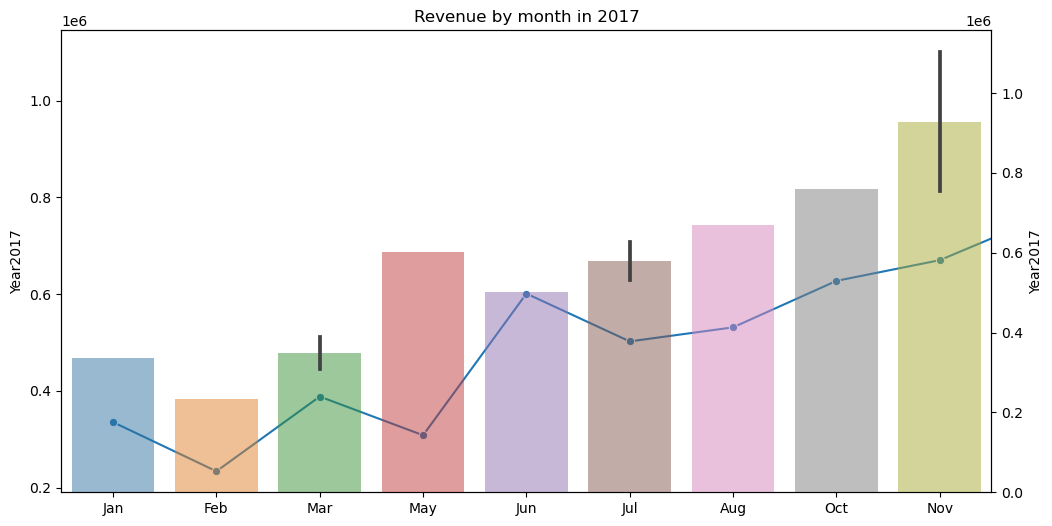

In [15]:
plot_revenue_by_month_year(revenue_by_month_year, 2017)

In [16]:
plot_top_10_revenue_categories(top_10_revenue_categories)

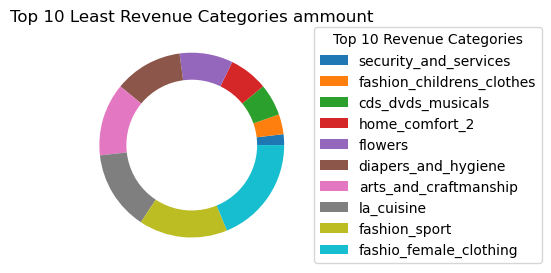

In [17]:
plot_top_10_least_revenue_categories(top_10_least_revenue_categories)

In [18]:
plot_revenue_per_state(revenue_per_state)

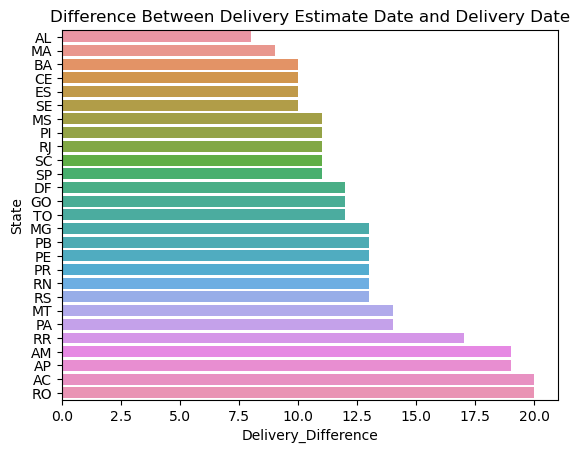

In [19]:
plot_delivery_date_difference(delivery_date_difference)

e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



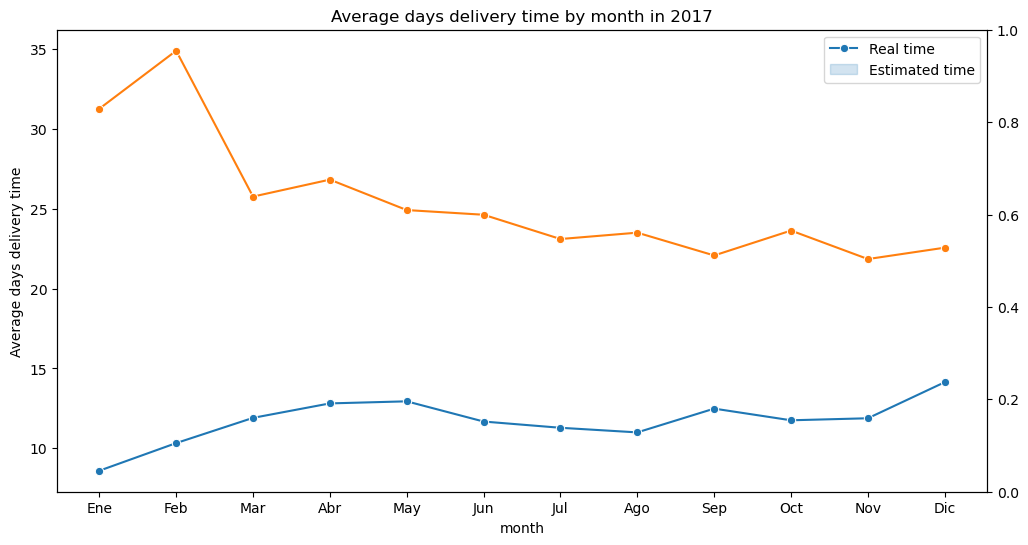

In [20]:
plot_real_vs_predicted_delivered_time(real_vs_estimated_delivered_time, year=2017)

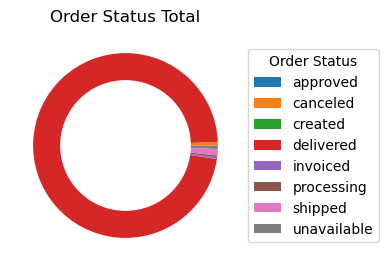

In [21]:
plot_global_amount_order_status(global_ammount_order_status)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         361 non-null    datetime64[ns]
 1   order_count  361 non-null    int64         
 2   holiday      361 non-null    bool          
dtypes: bool(1), datetime64[ns](1), int64(1)
memory usage: 6.1 KB
None


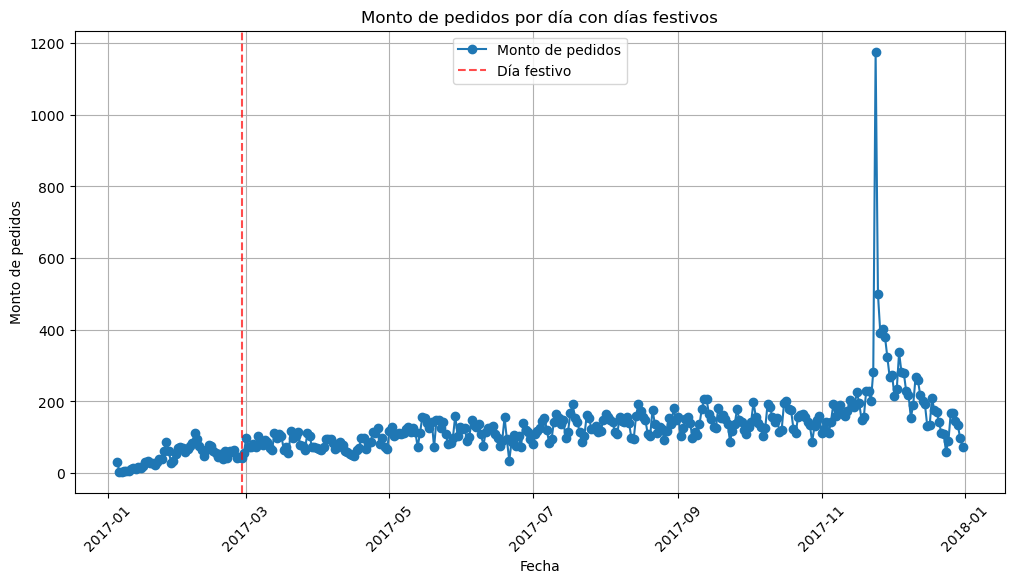

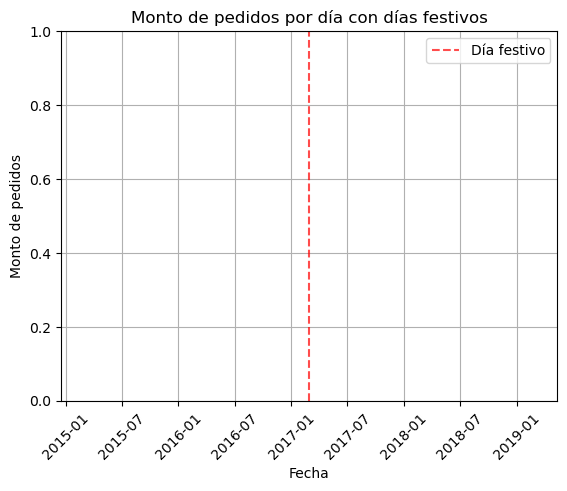

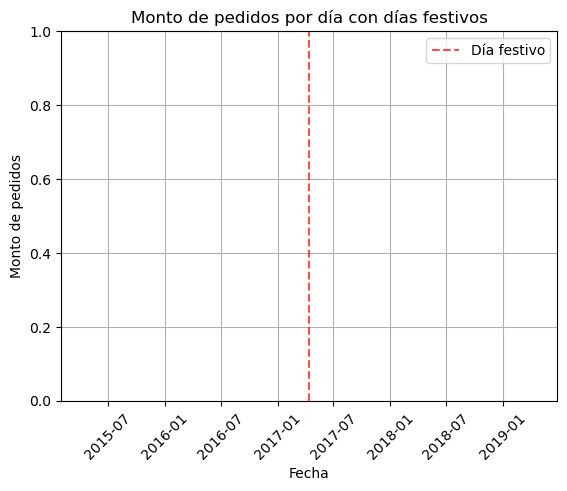

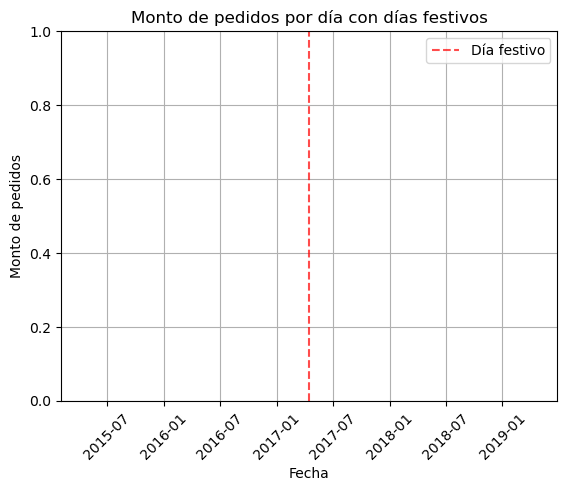

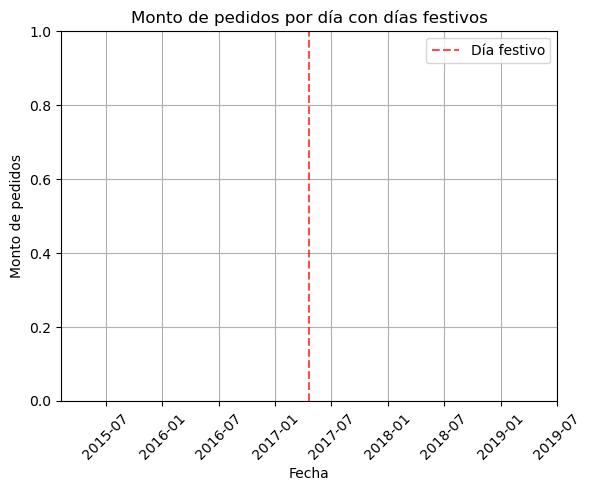

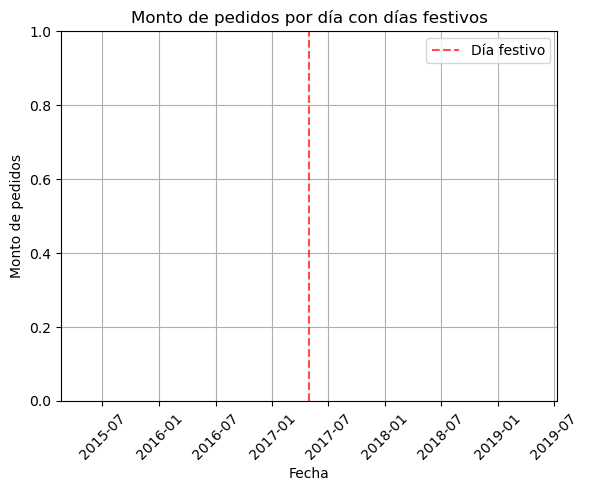

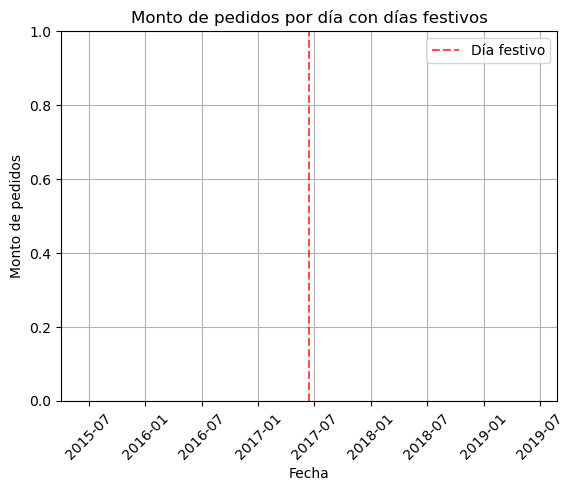

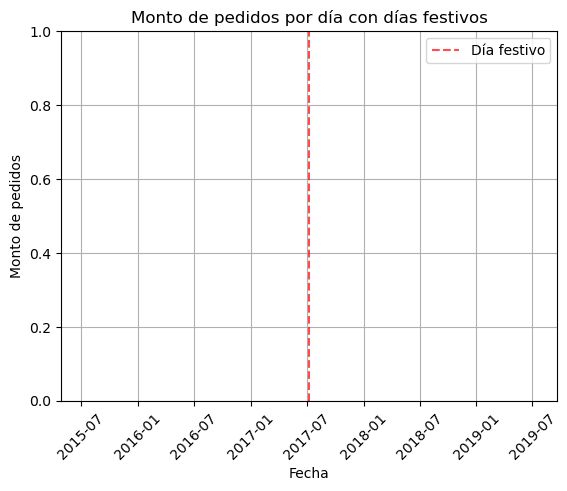

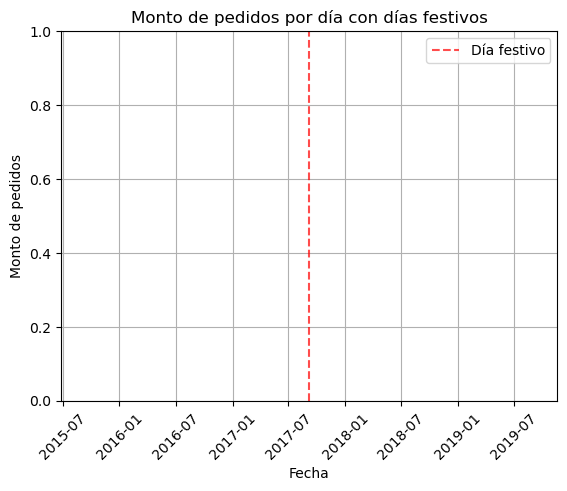

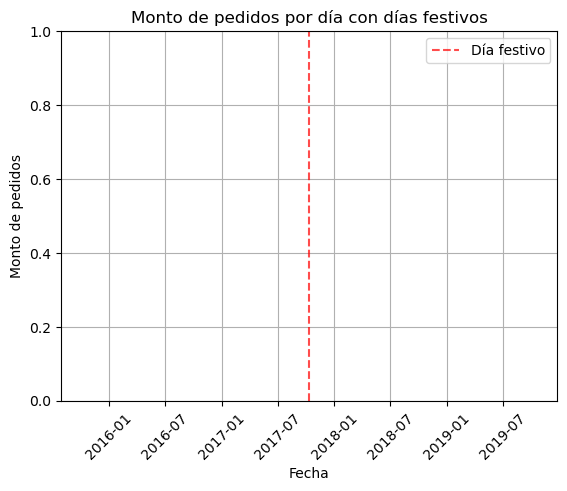

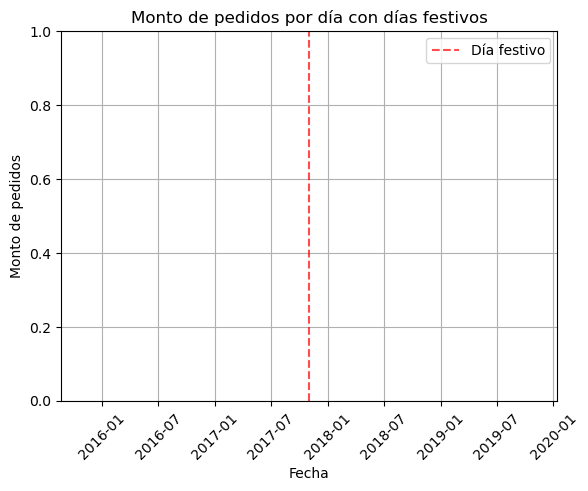

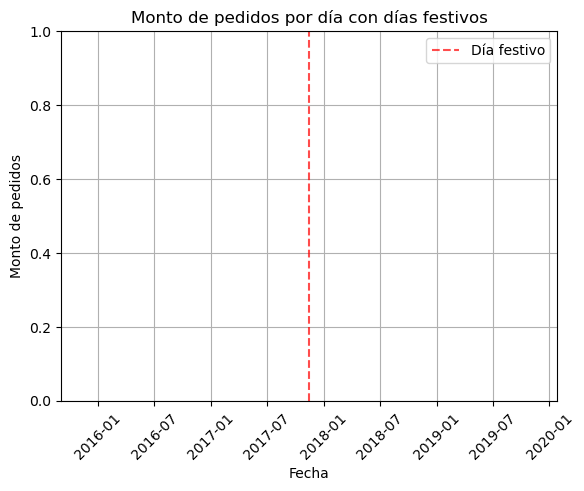

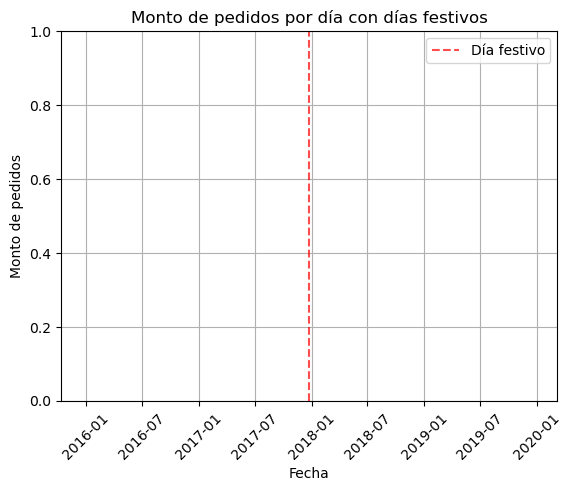

In [ ]:
#plot_order_amount_per_day_with_holidays(orders_per_day_and_holidays)
print(orders_per_day_and_holidays)

El gráfico de Pedidos por Día y Días Festivos que programarás en **src/plots.py** debe ser similar a este:

![The plot you will code will be similar to this:](images/orders_per_day_and_holidays.png "Orders per Day and Holidays")

4.1 ¿Ves alguna relación entre los días festivos en Brasil durante 2017 y las compras de ese año?

Respuesta: ________

In [23]:
plot_freight_value_weight_relationship(freight_value_weight_relationship)

NotImplementedError: 

El gráfico sobre la relación entre el valor del flete y el peso del producto que debes programar en `src/plots.py` tiene que ser similar a este:

![The plot you will code will be similar to this:](images/freight_value_weight_relationship.png "Freight Value and Weight Relationship")

4.2 ¿Ves alguna correlación entre el valor del flete y el peso del producto?

Respuesta:____